In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
# Set CUDA visible devices to 1 to avoid out of memory errors
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
noise = torch.load("noise.pt").to(device)
original_samples = torch.load("original_samples.pt").to(device)
sqrt_alpha_prod = torch.load("sqrt_alpha_prod.pt").to(device)
sqrt_one_minus_alpha_prod = torch.load("sqrt_one_minus_alpha_prod.pt").to(device)
x_mean = torch.load("original_samples_mean.pt")
x_std = torch.load("original_samples_std.pt")

In [3]:
random_noise = torch.randn_like(original_samples)
expected_l2_norm = torch.norm(random_noise, p=2)

In [5]:
def k_coef(a, b, c):
    m = torch.zeros_like(a).to(a.device, dtype=a.dtype)
    for i in range(c):
        m += a * b ** i
    n = b ** c
    return m, n

In [6]:
n_samples = 50
random_noise = torch.randn_like(original_samples)

coef_list = [k_coef(sqrt_alpha_prod.clone(), sqrt_one_minus_alpha_prod.clone(), i) for i in range(n_samples)]
sqrt_alpha_prod_list = [coef_list[i][0] for i in range(n_samples)]
sqrt_one_minus_alpha_prod_list = [coef_list[i][1] for i in range(n_samples)]
k_rnr = [(sqrt_alpha_prod_list[i] * original_samples + sqrt_one_minus_alpha_prod_list[i] * noise) for i in range(n_samples)]
expected = [sqrt_alpha_prod_list[0] * original_samples + sqrt_one_minus_alpha_prod_list[0] * random_noise] * n_samples
expected_mean = [sqrt_alpha_prod[0] * x_mean + sqrt_one_minus_alpha_prod_list[0] * random_noise] * n_samples
expected_std =  [((sqrt_alpha_prod * x_std)**2 + sqrt_one_minus_alpha_prod**2)**0.5] * n_samples

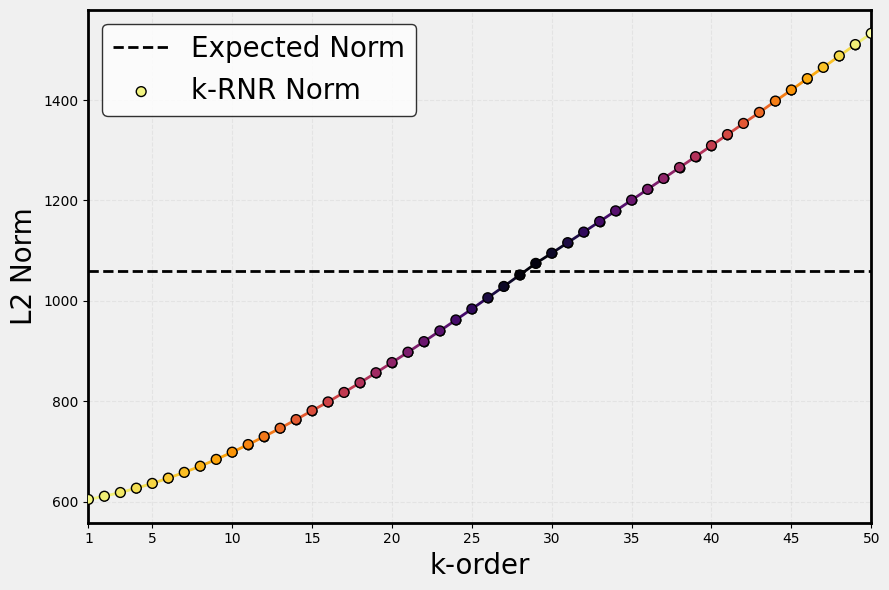

In [6]:
# Calculate L2 norms for k_rnr - convert to float first to avoid BFloat16 error
n_dim = 1
font_size = 20
k_rnr_norms = [torch.norm(sample.float(), p=2).cpu().numpy() / n_dim for sample in k_rnr]
expected_np  = [torch.norm(sample.float(), p=2).cpu().numpy() / n_dim for sample in expected]


# Create x-axis values (1 to n_samples)
x_values = list(range(1, n_samples + 1))

# Create the plot with a clean, professional style and gray background
plt.figure(figsize=(9, 6), facecolor='#F0F0F0')  # Light gray background
plt.plot(x_values, expected_np, '--', color='black', label='Expected Norm', linewidth=2)

# Calculate absolute differences between k_rnr_norms and expected values
abs_differences = [abs(k_rnr_norms[i] - expected_np[i]) for i in range(len(x_values))]
# Normalize differences for color mapping
max_diff = max(abs_differences)
normalized_diffs = [diff/max_diff for diff in abs_differences]
# Create colors based on the differences
colors = plt.cm.inferno(normalized_diffs)

# Plot with outline everywhere
for i in range(len(x_values)-1):
    plt.plot(x_values[i:i+2], k_rnr_norms[i:i+2], 'o-', color=colors[i], linewidth=2, markeredgecolor='black', markeredgewidth=1)
# Add a scatter plot with the same colors for better visibility of points
plt.scatter(x_values, k_rnr_norms, c=colors, s=50, zorder=5, label='k-RNR Norm', edgecolors='black', linewidths=1)

# Add labels and title with professional styling
plt.xlabel('k-order', fontsize=font_size)
plt.ylabel('L2 Norm', fontsize=font_size)
# plt.title('Comparison of Expected and k-RNR L2 Norms', fontsize=14, fontweight='bold')
plt.legend(frameon=True, edgecolor='black', fontsize=font_size)

# Ensure x-axis includes all points from 1 to n_samples
plt.xlim(1, n_samples)

# Set x-axis ticks to start with 1 and end with n_samples with some intermediate values
x_ticks = [1] + [5*i for i in range(1, 11)]
plt.xticks(x_ticks)

# Set all spines visible to create a rectangular box around the plot
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_edgecolor('black')
ax.spines['right'].set_edgecolor('black')
ax.spines['left'].set_edgecolor('black')
ax.spines['bottom'].set_edgecolor('black')
# Make all spines thicker
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Set the axes background color to match the figure
ax.set_facecolor('#F0F0F0')

# Add grid
plt.grid(True, linestyle='--', alpha=0.2)
plt.savefig('k_rnr_l2_norms_comparison.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()
# Export the plot as a PDF


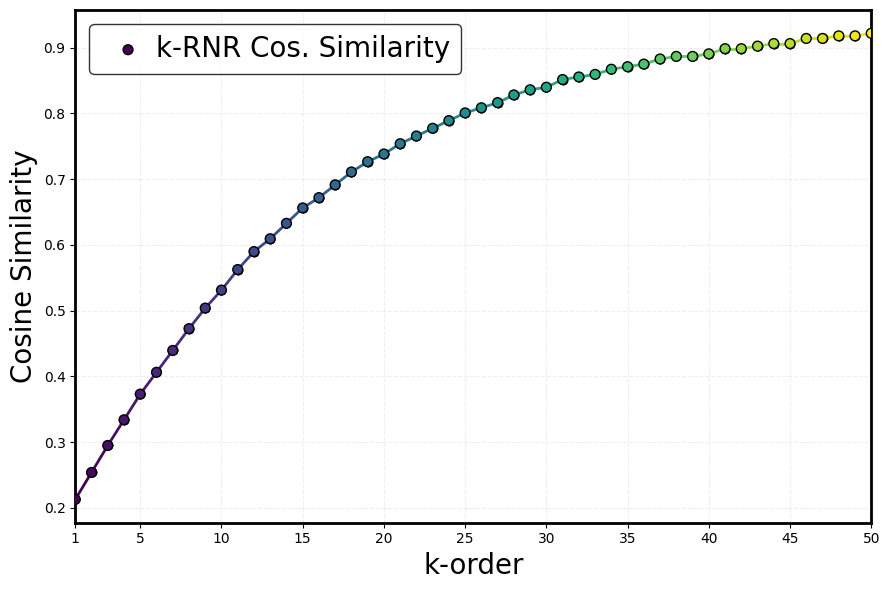

In [7]:
pivot = [original_samples] * n_samples
# Calculate cosine similarity between original samples and k-RNR samples
cosine_similarities = []
for i in range(n_samples):
    # Calculate cosine similarity
    cos_sim = F.cosine_similarity(original_samples.flatten(), k_rnr[i].flatten(), dim=0)
    cosine_similarities.append(cos_sim.item())

# Create a new figure with the same styling as before
plt.figure(figsize=(9, 6))

# Create a colormap for the line segments
colors = plt.cm.viridis(np.linspace(0, 1, n_samples))

# Plot line segments with different colors
for i in range(n_samples-1):
    plt.plot(x_values[i:i+2], cosine_similarities[i:i+2], 'o-', color=colors[i], linewidth=2, markeredgecolor='black', markeredgewidth=1)
# Add a scatter plot with the same colors for better visibility of points
plt.scatter(x_values, cosine_similarities, c=colors, s=50, zorder=5, label='k-RNR Cos. Similarity', edgecolors='black', linewidths=1)

# Add labels and title with professional styling
plt.xlabel('k-order', fontsize=font_size)
plt.ylabel('Cosine Similarity', fontsize=font_size)
plt.legend(frameon=True, edgecolor='black', fontsize=font_size, handletextpad=0.0001)  # Reduced space between legend symbol and text

# Ensure x-axis includes all points from 1 to n_samples
plt.xlim(1, n_samples)

# Set x-axis ticks to start with 1 and end with n_samples with some intermediate values
x_ticks = [1] + [5*i for i in range(1, 11)]
plt.xticks(x_ticks)

# Set all spines visible to create a rectangular box around the plot
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_edgecolor('black')
ax.spines['right'].set_edgecolor('black')
ax.spines['left'].set_edgecolor('black')
ax.spines['bottom'].set_edgecolor('black')
# Make all spines thicker
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)


# Add grid
plt.grid(True, linestyle='--', alpha=0.2)
plt.savefig('k_rnr_cosine_similarity.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()


In [8]:
def mean_std_k(k, x_mean, x_std, coefs, eps):
    coef_x0, coef_eps = coefs[k]
    mean = coef_x0 * x_mean + coef_eps * eps
    std = coef_x0 * x_std
    return mean, std

In [9]:
n_samples = 1000
coef_list = [k_coef(sqrt_alpha_prod.clone(), sqrt_one_minus_alpha_prod.clone(), i) for i in range(n_samples)]
mean_std_list = [mean_std_k(i, x_mean, x_std, coef_list, noise) for i in range(n_samples)]
mean_list = [mean_std_list[i][0] for i in range(n_samples)]
std_list = [mean_std_list[i][1] for i in range(n_samples)]

In [ ]:
# Create a figure for the mean values
every_n_sample = 15
plt.figure(figsize=(9, 6))
expected_mean = expected_mean * 12
# Plot the mean values - using L2 norm instead of direct values
colors = plt.cm.viridis(np.linspace(0, 1, n_samples))
expected_mean_norm  = [torch.norm(sample.float(), p=2).cpu().numpy() / n_dim for sample in expected_mean]

# Calculate L2 norms of mean values
mean_l2_norms = [torch.norm(mean, p=2).item() / n_dim for mean in mean_list]

# Make sure x_values start from 1
x_values = list(range(1, n_samples + 1))

# Create indices for every 50th element
scatter_indices = list(range(0, n_samples, every_n_sample))

# Plot only the selected points and lines between them (single call)
plt.plot([x_values[i] for i in scatter_indices], 
         [mean_l2_norms[i] for i in scatter_indices], 
         '-', linewidth=2, color='blue')

# Add scatter plot for the same points
plt.scatter([x_values[i] for i in scatter_indices], 
            [mean_l2_norms[i] for i in scatter_indices], 
            c=[colors[i] for i in scatter_indices], 
            s=50, zorder=5, label='k-RNR Mean', edgecolors='black', linewidths=1)

# plt.plot(x_values, expected_mean_norm, '--', color='black', label='Expected', linewidth=2)
# Set labels and title
plt.xlabel('k order', fontsize=font_size)
plt.ylabel('L2 Norm', fontsize=font_size)
plt.legend(frameon=True, edgecolor='black', fontsize=font_size)  # Reduced space between legend symbol and text
# plt.title('Mean Values (L2 Norm) for Different k Orders', fontsize=16)

# Ensure x-axis includes all points from 1 to n_samples
plt.xlim(1, n_samples)
# Set x-ticks
x_ticks = [1] + [i for i in range(1, n_samples, 200)]
plt.xticks(x_ticks)

# Set all spines visible to create a rectangular box around the plot
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_edgecolor('black')
ax.spines['right'].set_edgecolor('black')
ax.spines['left'].set_edgecolor('black')
ax.spines['bottom'].set_edgecolor('black')
# Make all spines thicker
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Add grid
plt.grid(True, linestyle='--', alpha=0.2)
plt.savefig('k_rnr_mean_values_l2norm.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

Text(0, 0.5, 'L2 Norm')

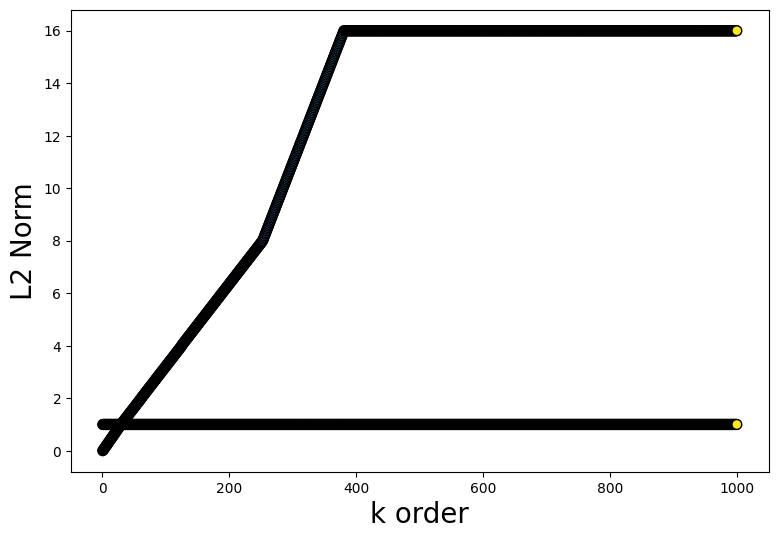

In [16]:
n_samples = 1000
coef_list = [k_coef(sqrt_alpha_prod.clone(), sqrt_one_minus_alpha_prod.clone(), i) for i in range(n_samples)]
coef_original = [coef_list[i][0] for i in range(n_samples)]
coef_noise = [coef_list[i][1] for i in range(n_samples)]
font_size = 20
coef_original_norm = [torch.norm(coef, p=2).item()  for coef in coef_original]
coef_noise_norm = [torch.norm(coef, p=2).item()  for coef in coef_noise]
plt.figure(figsize=(9, 6))
x_values = list(range(1, n_samples + 1))
colors = plt.cm.viridis(np.linspace(0, 1, n_samples))
plt.plot(x_values, coef_original_norm, '-', color='black', linewidth=2)
plt.plot(x_values, coef_noise_norm, '-', color='blue', linewidth=2)
plt.scatter(x_values, coef_original_norm, c=colors, s=50, zorder=5, label='k-RNR Coef', edgecolors='black', linewidths=1)
plt.scatter(x_values, coef_noise_norm, c=colors, s=50, zorder=5, label='k-RNR Coef', edgecolors='black', linewidths=1)
plt.xlabel('k order', fontsize=font_size)
plt.ylabel('L2 Norm', fontsize=font_size)